In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#Definition of the function "moment" to compute the moment, given the linear and ponctual loads for a simply supported beam
def moment(q,Q,L):
    M = (q*L**2)/8 + Q*L/4
    return print("Le moment maximal en travée vaut M = ", M, 'kNm')

In [5]:
#Definition of the function "shear" to compute the shear force, given the linear and ponctual loads for a simply supported beam
def shear(q,Q,L):
    V = q*L/2 + Q/2
    return print("L'effort tranchant maximal vaut V= ", V, 'kN')

In [6]:
#Code to define the orientations of the fibers in the different laminates and put it into a list
def orientation(liste):
    code_orientation = liste.split(",")
    for i in range(0,len(code_orientation)):
        code_orientation[i] = int(code_orientation[i])
        i +=1
    return code_orientation

In [7]:
# This function gives the deformation for each ply, given the mechanical parameters
def get_deformation(liste,E1,E2,nu21,nu12,G12,h,Nx,Ny,Nxy,Mx,My,Mxy):
    Q11 = E1/(1-nu21*nu12)
    Q12 = nu12*E2/(1-nu21*nu12)
    Q22 = E2/(1-nu21*nu12)
    Q66 = G12
    
    liste_different_orientation = []
   
    #To get the different angles of orientation of the fibers
    for i in range(0,len(liste)):
        if liste[i] in liste_different_orientation:
            continue
        else:
            liste_different_orientation.append(liste[i])
    
    liste_different_orientation = np.array(liste_different_orientation)
    
    Qtot = np.zeros((len(liste_different_orientation), 3, 3))
    
    # To get the different matrices Q at each ply
    for i in range(0,len(liste_different_orientation)):
        a = liste_different_orientation[i]*(np.pi/180)
        m = np.cos(a)
        n = np.sin(a)
        Qxx = Q11*m**4+Q22*n**4+2*(Q12+2*Q66)*m**2*n**2
        Qxy = (Q11+Q22-4*Q66)*m**2*n**2+Q12*(m**4+n**4)
        Qyy = Q11*n**4+Q22*m**4+2*(Q12+2*Q66)*m**2*n**2
        Qxs = (Q11-Q12-2*Q66)*m**3*n-(Q22-Q12-2*Q66)*n**3*m
        Qys = (Q11-Q12-2*Q66)*m*n**3-(Q22-Q12-2*Q66)*m**3*n
        Qss = (Q11+Q22-2*Q12-2*Q66)*m**2*n**2+Q66*(n**4+m**4)
        Qtot[i] = np.array([[Qxx,Qxy,Qxs],[Qxy,Qyy,Qys],[Qxs,Qys,Qss]])
        
    #To get the position of the different plies, with the origin at the centre of the plate (zd for down, zu for up), z axis oriented from up to down
     
    ply_pos = np.zeros((len(liste), 3))
    t = h/len(liste)
    
    for i in range(0,len(liste)):
        zu = -h/2+i*t
        zd = -h/2+(i+1)*t
        zm = (zu+zd)/2
        ply_pos[i] = np.array([[zu,zm,zd]])
        
    # Global coordinates
    coord  = ply_pos.reshape(3*len(ply_pos))
        
    #Definition of the matrices A,B,D
    A = np.zeros((3, 3))
    B = np.zeros((3, 3))
    D = np.zeros((3, 3))
    
    for i in range(0,len(liste)):
        Qx = np.zeros((3,3))
        ply_pos_i = np.array(ply_pos[i])
        for j in range(0,len(liste_different_orientation)):
            if liste[i] == liste_different_orientation[j]:
                Qx = Qtot[j]
            else:
                continue
        A += Qx*(ply_pos[i,2]-ply_pos[i,0])
        B += (1/2)*Qx*(ply_pos[i,2]**2-ply_pos[i,0]**2)
        D += (1/3)*Qx*(ply_pos[i,2]**3-ply_pos[i,0]**3)
        
        
    #Obtention of global strains and curvature (the x axis is in the direction of the length, the y axis perpendicular to it)
    force_array = np.array([Nx,Ny,Nxy,Mx,My,Mxy])
    sys = np.concatenate((np.concatenate((A, B), axis=1), np.concatenate((B,D),axis = 1)),axis = 0)
    sys_inv = np.linalg.inv(sys)
    global_deformation = sys_inv@force_array*10**-9
    
    #Obtention of the deformations and stresses at each slice of the composite
    
    eps_up = np.zeros((len(liste), 3))
    eps_mid = np.zeros((len(liste), 3))
    eps_down = np.zeros((len(liste), 3))
    eps_i = np.zeros((len(liste), 3,3))
    
    sig_up = np.zeros((len(liste), 3))
    sig_mid = np.zeros((len(liste), 3))
    sig_down = np.zeros((len(liste), 3))
    sig_i = np.zeros((len(liste), 3,3))
    
    for i in range(0, len(liste)):
        Qx = np.zeros((3,3))
        
        eps_up[i] = global_deformation[:3]+ply_pos[i,0]*global_deformation[3:]
        eps_mid[i] = global_deformation[:3]+((ply_pos[i,0]+ply_pos[i,2])/2)*global_deformation[3:]
        eps_down[i] = global_deformation[:3]+ply_pos[i,2]*global_deformation[3:]
        eps_i[i] = np.concatenate((np.concatenate((eps_up[i],eps_mid[i]),axis=0),eps_down[i]),axis=0).reshape(3,3)
        
        for j in range(0,len(liste_different_orientation)):
            if liste[i] == liste_different_orientation[j]:
                Qx = Qtot[j]
            else:
                continue
        sig_up[i] = Qx@eps_up[i]
        sig_mid[i] = Qx@eps_mid[i]
        sig_down[i] = Qx@eps_down[i]
        sig_i[i] = np.concatenate((np.concatenate((sig_up[i],sig_mid[i]),axis=0),sig_down[i]),axis=0).reshape(3,3)

    #plot of the results
    
    giga_eps = eps_i.reshape(3*len(liste),3)
    giga_sig = sig_i.reshape(3*len(liste),3)
    
    plt.figure(figsize=(15, 2))

    plt.subplot(131)
    plt.plot(giga_eps[:,0],coord)
    plt.plot(giga_eps[:,1],coord)
    plt.plot(giga_eps[:,2],coord)
    plt.subplot(132)
    plt.plot(giga_sig[:,0],coord)
    plt.plot(giga_sig[:,1],coord)
    plt.plot(giga_sig[:,2],coord)
    
    return sig_i


In [ ]:
def failure()

Donner les orientations des fibres en degré sous la forme: a,b,c...
[0, 30, -45]
Donner le module de Young dans la direction de la longueur (E1) en GPa: 
Donner le module de Young dans la direction de la largeur (E2) en GPa: 
Donner le coefficient de poisson nu12 : 
Donner le module de cisaillement G12 en GPa) : 
Donner l'épaisseur de la plaque en m : 
Donner la charge linéaire q en kN/m : 
Donner la charge ponctuelle Q en kN : 
Donner la longueur de la poutre en m : 


array([[[ 3.35132028e-05,  6.18753564e-05, -2.75037233e-05],
        [ 4.46400965e-05,  5.35937125e-05, -2.01518440e-05],
        [ 5.57669903e-05,  4.53120686e-05, -1.27999647e-05]],

       [[ 6.92970860e-05,  7.39141370e-05,  3.38075792e-05],
        [ 1.06330034e-04,  7.74678239e-05,  5.90317895e-05],
        [ 1.43362982e-04,  8.10215108e-05,  8.42559999e-05]],

       [[ 1.23528348e-04,  1.56279013e-04, -1.18672465e-04],
        [ 4.90298694e-05,  6.89384636e-05, -3.88799455e-05],
        [-2.54686095e-05, -1.84020862e-05,  4.09125741e-05]]])

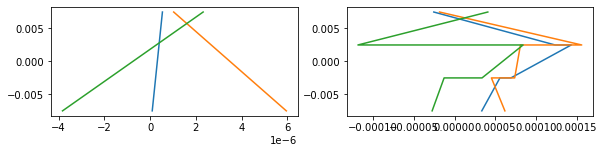

In [8]:
#Test of the function get_deformation
liste = input("Donner les orientations des fibres en degré sous la forme: a,b,c...") or "0, 30, -45"
liste = orientation(liste)
print(liste)
E1 = float(input("Donner le module de Young dans la direction de la longueur (E1) en GPa: " ) or 181)
E2 = float(input("Donner le module de Young dans la direction de la largeur (E2) en GPa: " ) or 10.3)
nu12 = float(input("Donner le coefficient de poisson nu12 : " ) or 0.28)
nu21 = (E2/E1)*nu12
G12=float(input("Donner le module de cisaillement G12 en GPa) : " ) or 7.17)
h = float(input("Donner l'épaisseur de la plaque en m : " ) or 0.015)
q = float(input("Donner la charge linéaire q en kN/m : " ) or 0)
Q = float(input("Donner la charge ponctuelle Q en kN : " ) or 0)
L = float(input("Donner la longueur de la poutre en m : " ) or 10)
#Mx = moment(q,Q,L)
#Nx = Ny = Nxy = My = Mxy = 0
Nx = Ny = 1000
Mx = My = Mxy = Nxy = 0
get_deformation(liste,E1,E2,nu21,nu12,G12,h,Nx,Ny,Nxy,Mx,My,Mxy)